In [1]:
from google.colab import drive
drive.mount('/content/drive')



Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:35<00:00, 16212969.51it/s]


In [4]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)
print(device)

cuda


In [0]:
from matplotlib.pyplot import imshow
import time
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    #imshow(image)
    #time.sleep(30)
    
    size = min(max(image.size),max_size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
ROOT =  "/content/drive/My Drive"

content = load_image(ROOT+'/style-transfer/images/octopus.jpg').to(device)
style = load_image(ROOT+'/style-transfer/images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [11]:
print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 592])
torch.Size([1, 3, 400, 592])


In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

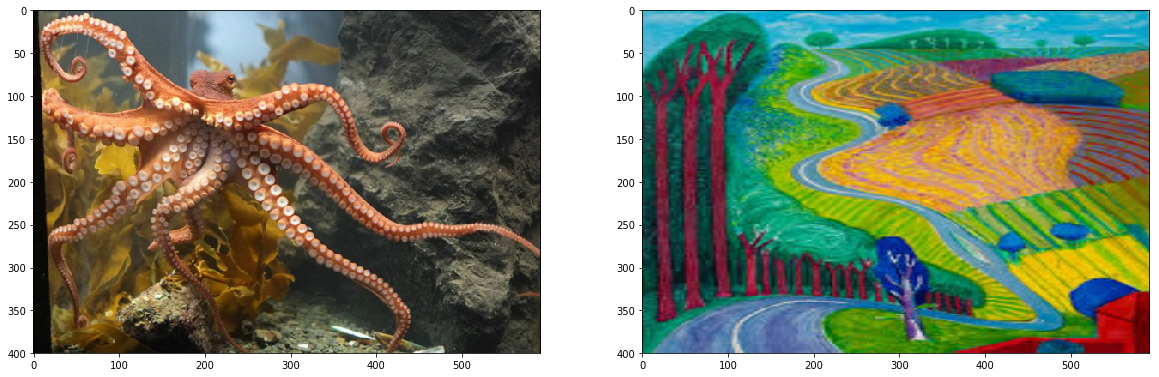

In [13]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [14]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def get_features(image, model, layers=None):
    if layers is None:
         layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    
    gram = None
    batch_size,depth,height,width = tensor.shape
    tensor = tensor.view(depth,height*width)
    tensor_bar = tensor.t()
    gram = torch.matmul(tensor,tensor_bar)
    
    return gram 

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
target = content.clone().requires_grad_(True).to(device)

In [18]:
for key,value in content_features.items():
    print(key," : ",value.shape)

conv1_1  :  torch.Size([1, 64, 400, 592])
conv2_1  :  torch.Size([1, 128, 200, 296])
conv3_1  :  torch.Size([1, 256, 100, 148])
conv4_1  :  torch.Size([1, 512, 50, 74])
conv4_2  :  torch.Size([1, 512, 50, 74])
conv5_1  :  torch.Size([1, 512, 25, 37])


In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e4  # beta

Total loss:  5780218.5


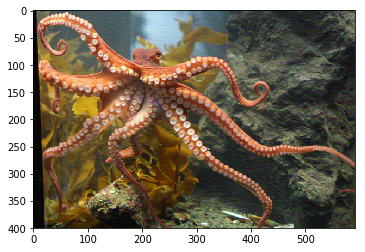

Total loss:  4406168.5


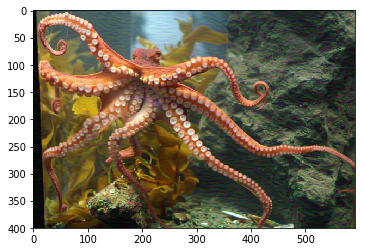

Total loss:  3700927.25


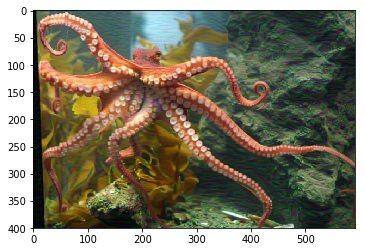

Total loss:  3088837.75


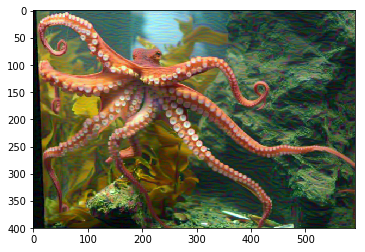

Total loss:  2478091.0


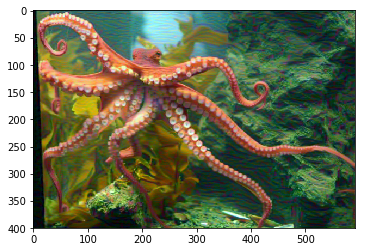

Total loss:  1884630.75


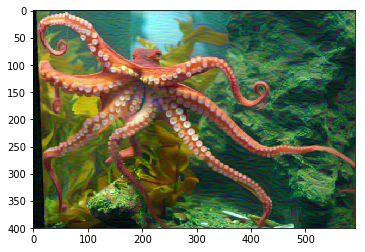

Total loss:  1364532.125


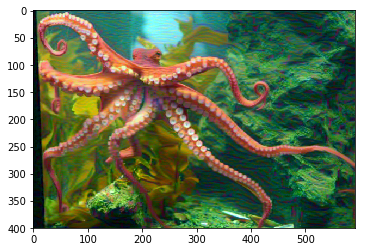

Total loss:  962582.5625


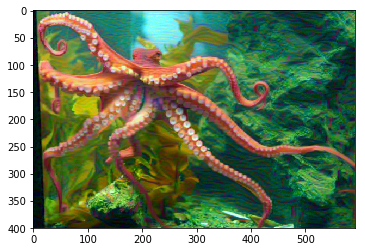

Total loss:  681835.4375


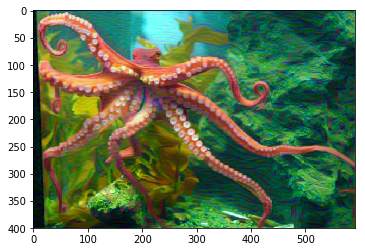

Total loss:  495441.21875


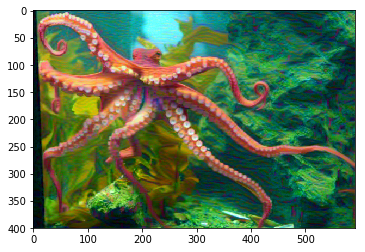

Total loss:  372992.1875


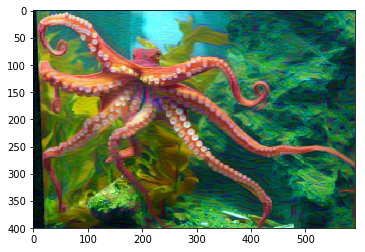

Total loss:  292063.90625


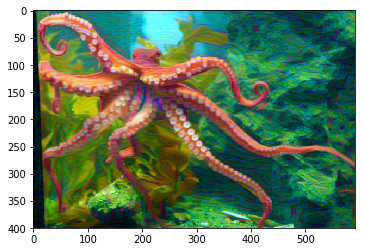

KeyboardInterrupt: ignored

In [26]:
show_every = 50

optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    
    target_features = get_features(target,vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:

        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_feature = style_features[layer]
        style_gram = gram_matrix(style_feature)

        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
        
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

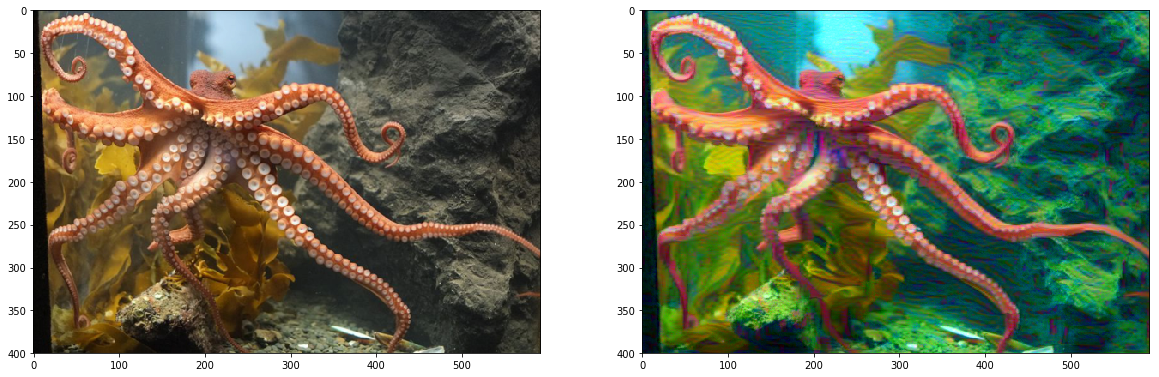

In [27]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))